# Validation of PRMS6 Surface and Soil BMI Coupling

The purpose of this notebook is to show an example coupling of the PRMS6 Surfac and Soil BMI using the pipestem example and comparing the coupled solution with the solution run in PRMS6

* The surface-BMI builds on PRMS6 by Parker Norton (USGS)
    * https://github.com/nhm-usgs/prms/releases/tag/6.0.0_bmi-testing
* The Fortran BMIs by Rich McDonald and Steve Markstrom (USGS)
    * https://github.com/nhm-usgs/bmi-prms6-surface
    * https://github.com/nhm-usgs/bmi-prms6-soil
* The CSDMS-BMI-PyMT package by Mark Piper and Eric Hutton (CSDMS, CU-Boulder)
    * https://github.com/pymt-lab/pymt_prms_surface
    * https://github.com/pymt-lab/pymt_prms_soil
* More info about PyMT
    * https://csdms.github.io/pymt/
    
    
## Demo of the Pipestem project

In [1]:
%matplotlib inline
import numpy as np
from pymt.models import PRMSSurface, PRMSSoil
from pathlib import Path
import prms6bmi
import geopandas as gpd
import pandas as pd

➡ models: PRMSSurface, PRMSSoil


In [2]:
run_dir = '../prms/pipestem'
config_surf= 'control_surface.simple1'
config_soil = 'control_soil.simple1'
print(Path(run_dir).exists())
print((Path(run_dir) / config_surf).exists())
print((Path(run_dir) / config_soil).exists())
      
msurf = PRMSSurface()
msoil = PRMSSoil()

print(msurf.name, msoil.name)


True
True
True
prms6-surface-BMI prms6-BMI-SOIL


---
Surface and Soil exchange functions

---

In [3]:
soil_input_cond_vars = ['soil_rechr_chg', 'soil_moist_chg']

soil_input_vars = ['hru_ppt', 'hru_area_perv', 'hru_frac_perv', 'dprst_evap_hru', 
                   'dprst_seep_hru', 'infil', 'sroff','potet', 'hru_intcpevap', 
                   'snow_evap', 'snowcov_area', 'soil_rechr', 'soil_rechr_max', 
                   'soil_moist', 'soil_moist_max', 'hru_impervevap' , 
                   'srunoff_updated_soil','transp_on']

soil2surf_vars = ['infil', 'sroff', 'soil_rechr', 'soil_moist']

def surface2soil(msurf, msoil, exch_vars, cond_vars, dprst_flag, imperv_flag):
    for var in exch_vars:
        msoil.set_value(var, msurf.get_value(var))
    if dprst_flag in [1, 3] or imperv_flag in [1, 3]:
        for var in cond_vars:
            msoil.set_value(var, msurf.get_value(var))

def soil2surface(msoil, msurf, exch_vars):
    for var in exch_vars:
        msurf.set_value(var, msoil.get_value(var))
        


In [4]:
msurf.initialize(config_surf, run_dir)
msoil.initialize(config_soil, run_dir)

---
Create a function of the coupled update() command

---

In [5]:
dprst_flag = msoil.get_value('dyn_dprst_flag')
imperv_flag = msoil.get_value('dyn_imperv_flag')

def update_coupled(msurf, msoil, dprst_flag, imperv_flag):
    msurf.update()
    surface2soil(msurf, msoil, soil_input_vars, soil_input_cond_vars, dprst_flag, imperv_flag)
    msoil.update()
    soil2surface(msoil, msurf, soil2surf_vars)

In [6]:
# Get time information from the model.
print(f'Start time Surface/Soil: {msurf.start_time}/{msoil.start_time}')
print(f'End time Surface/Soil: {msurf.end_time}/{msoil.end_time}')
print(f'Current time Surface/Soil: {msurf.end_time}/{msoil.end_time}')
print('Nowtime Surface/Soil:', msurf.var['nowtime'].data, msoil.var['nowtime'].data)

Start time Surface/Soil: 0.0/0.0
End time Surface/Soil: 731.0/731.0
Current time Surface/Soil: 731.0/731.0
Nowtime Surface/Soil: [1980    1    1    0    0    0] [1980    1    1    0    0    0]


---
Run the coupled BMI

---

In [7]:
for i in range(int(msurf.start_time),int(msurf.end_time)):
    update_coupled(msurf, msoil, dprst_flag, imperv_flag)

In [8]:
# msurf.finalize()
# msoil.finalize()

---
Read the pipestem shapefile and reorder HRUs to match HRU order in pipestem example

---

In [9]:
gdf = gpd.read_file('GIS/pipestem_hru_geographic.shp')
gdf.head()

pd.set_option('mode.chained_assignment', None)
gdf_ps = gdf[gdf['hru_id'].isin(msurf.var['nhm_id'].data)]
print(type(msurf.var['nhm_id'].data))
dindex = np.zeros(np.shape(gdf_ps.hru_id.values), dtype=np.int8)
for index, val in np.ndenumerate(msurf.var['nhm_id'].data):
    tind = np.int(np.where(gdf_ps['hru_id'].values == msurf.var['nhm_id'].data[index])[0])
#     print(type(tind), tind)
    dindex[tind] = np.array([index])
print(dindex)
# # gdf_ps['tindex'] = 0
gdf_ps.loc[:,'tindex'] = dindex
# # # gdf_ps.Index.sort_values()
gdf_ps.sort_values(by=['tindex'], inplace=True)
gdf_ps

<class 'numpy.ndarray'>
[12 13  4 10 11  5  0  1  2  6  7  3  8  9]


,LAYER,hru_id_loc,hru_id,region,geometry,tindex
14,Unknown Area Type,2291,57874,r10u,"POLYGON ((-240014.760 2709947.868, -240014.745...",0
15,Unknown Area Type,2292,57875,r10u,"POLYGON ((-241514.933 2720894.818, -241484.800...",1
16,Unknown Area Type,2295,57878,r10u,"POLYGON ((-263236.937 2720624.914, -263264.907...",2
19,Unknown Area Type,2298,57881,r10u,"POLYGON ((-263204.777 2722334.992, -263204.712...",3
10,Unknown Area Type,2285,57868,r10u,"POLYGON ((-237983.320 2707604.941, -237970.681...",4
13,Unknown Area Type,2290,57873,r10u,"MULTIPOLYGON (((-233025.091 2696955.163, -2330...",5
17,Unknown Area Type,2296,57879,r10u,"POLYGON ((-256485.222 2718105.125, -256455.090...",6
18,Unknown Area Type,2297,57880,r10u,"POLYGON ((-257828.084 2725785.089, -257827.820...",7
20,Unknown Area Type,2299,57882,r10u,"MULTIPOLYGON (((-245144.770 2725005.157, -2451...",8
21,Unknown Area Type,2300,57883,r10u,"POLYGON ((-255345.272 2728364.935, -255345.177...",9


---
Open output from PRMS6 and the Surface and Soil BMI's for comparison plots

---

In [10]:
import xarray as xr
soil_file = Path('../prms/pipestem/output/summary_soil_daily.nc')
surf_file = Path('../prms/pipestem/output/summary_surf_daily.nc')
prms_file = Path('../prms/pipestem/output/summary_prms_daily.nc')
clim_file = Path('../prms/pipestem/daymet.nc')
dsoil = xr.open_dataset(soil_file)
dprms = xr.open_dataset(prms_file)
dsurf = xr.open_dataset(surf_file)
clim = xr.open_dataset(clim_file)

In [11]:
clim_date_min = clim.time.min().values
clim_date_max = clim.time.max().values
print(clim_date_min, clim_date_max)
# clim

1980-01-01T00:00:00.000000000 2016-12-31T00:00:00.000000000


In [12]:
sim_start_date = dsoil.time.min()
sim_end_date = dsoil.time.max()

In [13]:
dsoil

<xarray.Dataset>
Dimensions:              (nhru: 14, nsegment: 7, time: 731)
Coordinates:
  * time                 (time) datetime64[ns] 1980-01-01 ... 1981-12-31
Dimensions without coordinates: nhru, nsegment
Data variables:
    nhm_id               (nhru) int32 ...
    nhm_seg              (nsegment) int32 ...
    hru_actet            (time, nhru) float32 ...
    hru_impervevap       (time, nhru) float32 ...
    hru_intcpevap        (time, nhru) float32 ...
    snow_evap            (time, nhru) float32 ...
    perv_actet           (time, nhru) float32 ...
    slow_flow            (time, nhru) float32 ...
    recharge             (time, nhru) float32 ...
    soil_moist           (time, nhru) float32 ...
    soil_moist_tot       (time, nhru) float32 ...
    soil_to_gw           (time, nhru) float32 ...
    ssr_to_gw            (time, nhru) float32 ...
    ssres_flow           (time, nhru) float32 ...
    dprst_seep_hru       (time, nhru) float64 ...
    dprst_evap_hru       (time, nhru) float32 ...
    infil                (time, nhru) float32 ...
    sroff                (time, nhru) float32 ...
    dunnian_flow         (time, nhru) float32 ...
    pkwater_equiv        (time, nhru) float64 ...
    snowmelt             (time, nhru) float32 ...
    soil_rechr           (time, nhru) float32 ...
    contrib_fraction     (time, nhru) float32 ...
    potet                (time, nhru) float32 ...
    basin_potet          (time) float64 ...
    basin_sroff          (time) float64 ...
    gwres_flow           (time, nhru) float32 ...
    gw_in_soil           (time, nhru) float64 ...
    gw_in_ssr            (time, nhru) float64 ...
    hru_outflow          (time, nhru) float64 ...
    seg_gwflow           (time, nsegment) float64 ...
    seg_sroff            (time, nsegment) float64 ...
    seg_ssflow           (time, nsegment) float64 ...
    seg_inflow           (time, nsegment) float64 ...
    seg_outflow          (time, nsegment) float64 ...
    seg_upstream_inflow  (time, nsegment) float64 ...

In [14]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

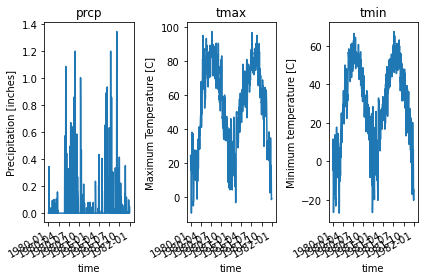

In [15]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('axes.formatter', useoffset=False)
fig, ax = plt.subplots(ncols=3)
t_hru = 13
prms6bmi.plot_climate(clim, t_hru, 'prcp', sim_start_date, sim_end_date, ax[0])
prms6bmi.plot_climate(clim, t_hru, 'tmax', sim_start_date, sim_end_date, ax[1])
prms6bmi.plot_climate(clim, t_hru, 'tmin', sim_start_date, sim_end_date, ax[2])
plt.tight_layout()
plt.show()

---
The variables plotted below are the variables that are calculated in both the Surface and Soil BMIs and exchanged between both BMIs

---

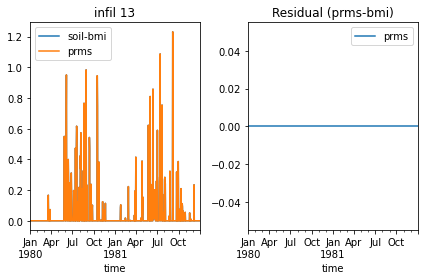

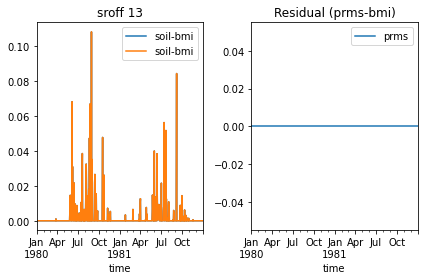

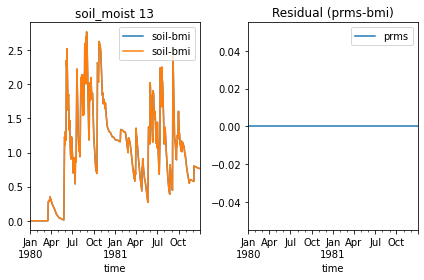

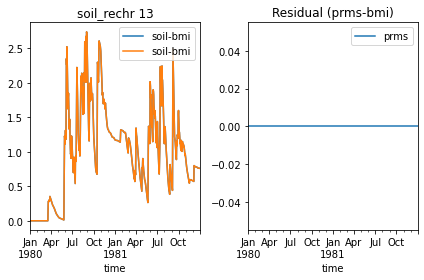

In [16]:
t_hru = 13

fig, ax = plt.subplots(ncols=2)
prms6bmi.bmi_prms6_value_plot(dsoil, t_hru, 'infil', 'soil-bmi', sim_start_date, sim_end_date, ax[0])
prms6bmi.bmi_prms6_value_plot(dprms, t_hru, 'infil', 'prms', sim_start_date, sim_end_date, ax[0])
prms6bmi.bmi_prms6_residual_plot(dsoil, dprms, t_hru, 'infil', 'prms', sim_start_date, sim_end_date, ax[1])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(ncols=2)
prms6bmi.bmi_prms6_value_plot(dsoil, t_hru, 'sroff', 'soil-bmi', sim_start_date, sim_end_date, ax[0])
prms6bmi.bmi_prms6_value_plot(dprms, t_hru, 'sroff', 'soil-bmi', sim_start_date, sim_end_date, ax[0])
prms6bmi.bmi_prms6_residual_plot(dsoil, dprms, t_hru, 'sroff', 'prms', sim_start_date, sim_end_date, ax[1])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(ncols=2)
prms6bmi.bmi_prms6_value_plot(dsoil, t_hru, 'soil_moist', 'soil-bmi', sim_start_date, sim_end_date, ax[0])
prms6bmi.bmi_prms6_value_plot(dprms, t_hru, 'soil_moist', 'soil-bmi', sim_start_date, sim_end_date, ax[0])
prms6bmi.bmi_prms6_residual_plot(dsoil, dprms, t_hru, 'soil_moist', 'prms', sim_start_date, sim_end_date, ax[1])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(ncols=2)
prms6bmi.bmi_prms6_value_plot(dsoil, t_hru, 'soil_rechr', 'soil-bmi', sim_start_date, sim_end_date, ax[0])
prms6bmi.bmi_prms6_value_plot(dprms, t_hru, 'soil_rechr', 'soil-bmi', sim_start_date, sim_end_date, ax[0])
prms6bmi.bmi_prms6_residual_plot(dsoil, dprms, t_hru, 'soil_rechr', 'prms', sim_start_date, sim_end_date, ax[1])
plt.gca().ticklabel_format(axis='y', style='plain', useOffset=False)
plt.tight_layout()
plt.show()


---
The variables below are the input the the groundwater bmi

---

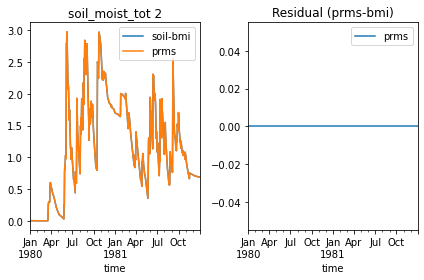

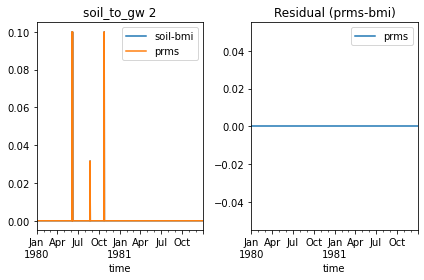

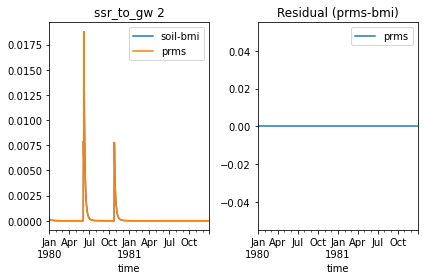

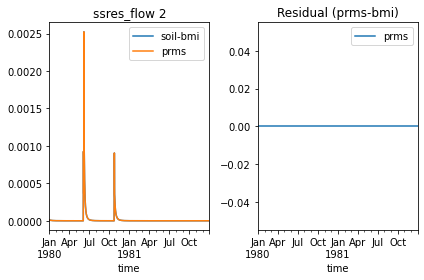

In [17]:
t_hru = 2

fig, ax = plt.subplots(ncols=2)
prms6bmi.bmi_prms6_value_plot(dsoil, t_hru, 'soil_moist_tot', 'soil-bmi', sim_start_date, sim_end_date, ax[0])
prms6bmi.bmi_prms6_value_plot(dprms, t_hru, 'soil_moist_tot', 'prms', sim_start_date, sim_end_date, ax[0])
prms6bmi.bmi_prms6_residual_plot(dsoil, dprms, t_hru, 'soil_moist_tot', 'prms', sim_start_date, sim_end_date, ax[1])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(ncols=2)
prms6bmi.bmi_prms6_value_plot(dsoil, t_hru, 'soil_to_gw', 'soil-bmi', sim_start_date, sim_end_date, ax[0])
prms6bmi.bmi_prms6_value_plot(dprms, t_hru, 'soil_to_gw', 'prms', sim_start_date, sim_end_date, ax[0])
prms6bmi.bmi_prms6_residual_plot(dsoil, dprms, t_hru, 'soil_to_gw', 'prms', sim_start_date, sim_end_date, ax[1])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(ncols=2)
prms6bmi.bmi_prms6_value_plot(dsoil, t_hru, 'ssr_to_gw', 'soil-bmi', sim_start_date, sim_end_date, ax[0])
prms6bmi.bmi_prms6_value_plot(dprms, t_hru, 'ssr_to_gw', 'prms', sim_start_date, sim_end_date, ax[0])
prms6bmi.bmi_prms6_residual_plot(dsoil, dprms, t_hru, 'ssr_to_gw', 'prms', sim_start_date, sim_end_date, ax[1])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(ncols=2)
prms6bmi.bmi_prms6_value_plot(dsoil, t_hru, 'ssres_flow', 'soil-bmi', sim_start_date, sim_end_date, ax[0])
prms6bmi.bmi_prms6_value_plot(dprms, t_hru, 'ssres_flow', 'prms', sim_start_date, sim_end_date, ax[0])
prms6bmi.bmi_prms6_residual_plot(dsoil, dprms, t_hru, 'ssres_flow', 'prms', sim_start_date, sim_end_date, ax[1])
plt.gca().ticklabel_format(axis='y', style='plain', useOffset=False)
plt.tight_layout()
plt.show()